In [1385]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def printimg(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

# Function to check if the bounding box is approximately square
def isSquare(siz):
    ratio = abs(siz[0] - siz[1]) / siz[0]  # Calculate width-to-height ratio
    # If the ratio difference is small, consider it square
    if ratio < 0.1:
        return True
    else:
        return False

# Function to check if a contour is approximately circular based on arc length
def isCircle(cnt):
    (x, y), radius = cv2.minEnclosingCircle(cnt)  # Minimum enclosing circle for contour
    length = cv2.arcLength(cnt, True)  # Perimeter of contour
    ratio = abs(length - np.pi * 2.0 * radius) / (np.pi * 2.0 * radius)  # Arc length ratio
    # If the ratio difference is small, consider it circular
    if ratio < 0.1:
        return True
    else:
        return False

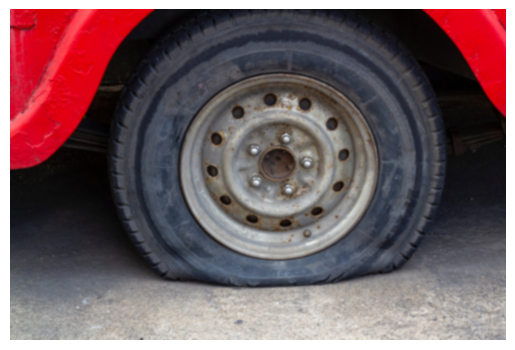

In [1386]:
# Read the image from the file
image = cv2.imread('img/rgb/000304.jpg')

# Apply Gaussian blur to smooth the image
blurred = cv2.GaussianBlur(image, (7, 7), 0)

# Show the blurred image
printimg(blurred)

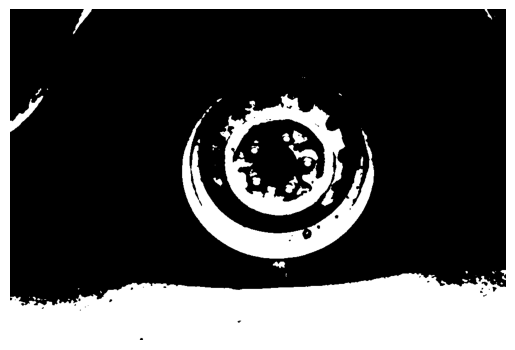

In [1387]:
# Define a rectangle for the region of interest
height = image.shape[0]  # Get the height of the image
width = image.shape[1]   # Get the width of the image
image_area = height * width
# Convert the foreground image to grayscale
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

# Pixels brighter than 40 are set to 255 (white), others to 0 (black)
_, dst = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY)

# Show the thresholded image
printimg(dst)


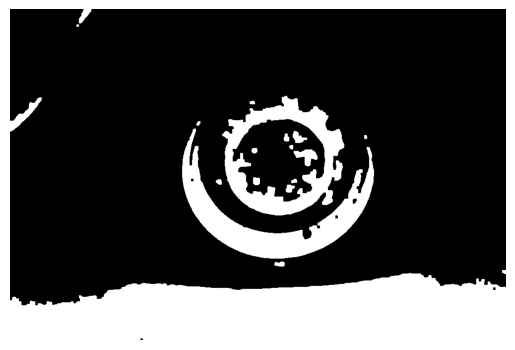

In [1388]:
# 使用闭操作填充边缘中的小洞
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
morph_dst = dst.copy()
for _ in range(3):
    morph_dst = cv2.morphologyEx(morph_dst, cv2.MORPH_OPEN, kernel)
    morph_dst = cv2.morphologyEx(morph_dst, cv2.MORPH_CLOSE, kernel)
printimg(morph_dst)

In [1389]:
# Detect contours in the processed image
cont, hier = cv2.findContours(morph_dst, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

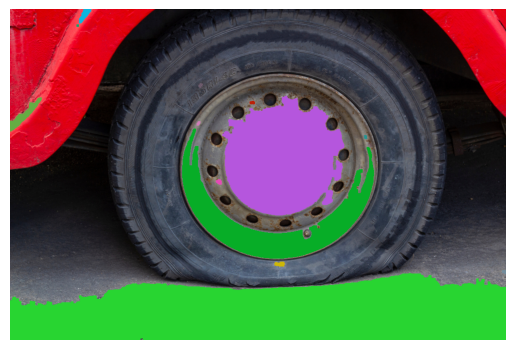

In [1390]:
# 轮廓检测
cont, hier = cv2.findContours(morph_dst, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_copy=image.copy()
for c in cont:
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.drawContours(img_copy, [c], -1, color, -1)
printimg(img_copy)

Closest eccentricity: 0.215


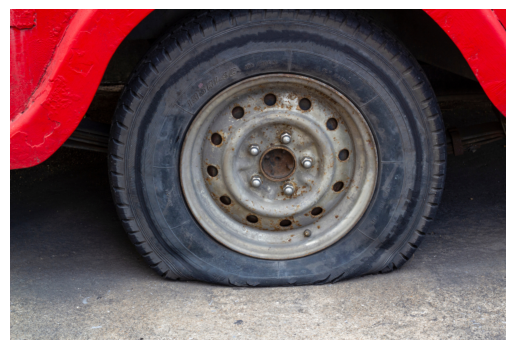

In [1391]:
# 遍历轮廓并根据层级信息筛选
closest_eccentricity = float('inf')  # 初始化最小离心率
closest_ellipse = None  # 存储离心率最小的椭圆参数

for c in cont:
    # 计算轮廓面积
    area = cv2.contourArea(c)
    # 面积过滤：确保轮廓面积大于图片面积的五十分之一
    if area > image_area / 50:
        x, y, w, h = cv2.boundingRect(c)
        flat_ratio = h / float(w)

        if len(c) >= 5:  # At least 5 points are required to fit an ellipse
            min_enclosing_ellipse = cv2.fitEllipse(c)  # Fit the ellipse

            # 计算离心率
            (center, axes, angle) = min_enclosing_ellipse
            major_axis = max(axes)
            minor_axis = min(axes)
            eccentricity = (1 - (minor_axis / major_axis) ** 2) ** 0.5

            # 检查离心率是否最接近圆（eccentricity 接近 0）
            if eccentricity < closest_eccentricity:
                closest_eccentricity = eccentricity
                closest_ellipse = min_enclosing_ellipse

        # 绘制轮廓和状态
        #cv2.drawContours(image, [c], -1, color, 2)
        status = f"Eccentricity: {eccentricity:.3f}"
        cv2.putText(img_copy, status, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# 如果找到最接近圆的椭圆，绘制它
if closest_ellipse is not None:
    cv2.ellipse(img_copy, closest_ellipse, (0, 255, 0), 2)  # 绿色椭圆
    print(f"Closest eccentricity: {closest_eccentricity:.3f}")
else:
    print("No valid ellipse found.")

printimg(image)


In [1392]:
closest_eccentricity

0.21470773381028352

Rectangle coordinates: (x=215, y=-24, width=554, height=564)


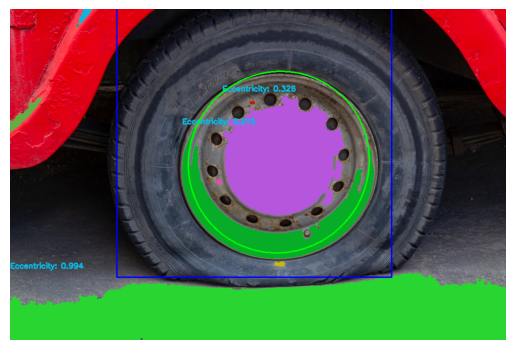

In [1393]:
# 确保已经找到最接近圆形的椭圆
if closest_ellipse is not None:
    # 获取椭圆参数
    (cx, cy), (major_axis, minor_axis), angle = closest_ellipse

    # 将角度从度数转换为弧度
    angle_rad = np.deg2rad(angle)

    # 计算椭圆在水平和垂直方向的投影长度
    horizontal_projection = abs(major_axis * np.cos(angle_rad)) + abs(minor_axis * np.sin(angle_rad))
    vertical_projection = abs(major_axis * np.sin(angle_rad)) + abs(minor_axis * np.cos(angle_rad))

    # 定义扩展比例因子
    scale_factor_w = 1.2 + closest_eccentricity * 0.3
    scale_factor_h = 1.2 + closest_eccentricity * 0.4

    # 扩展后的矩形宽高
    expanded_width = horizontal_projection * scale_factor_w
    expanded_height = vertical_projection * scale_factor_h

    # 确定垂直矩形的左上角 (x, y)
    x = int(cx - expanded_width / 2)
    y = int(cy - expanded_height / 2)

    # 确定垂直矩形的宽和高
    width = int(expanded_width * 0.85)
    height = int(expanded_height * 0.85)
    if closest_eccentricity > 0.7:
        if 0 <= angle <= 90:  # 第一象限，向左扩展
            x = x - int(closest_eccentricity * 100)
            width = width - int(closest_eccentricity * 50)
        elif 90 <= angle <= 180:  # 第三象限，向右扩展
            x = x + int(closest_eccentricity * 100)
            width = width + int(closest_eccentricity * 50)


    # 绘制垂直矩形
    cv2.rectangle(img_copy, (x, y), (x + width, y + height), (255, 0, 0), 2)  # 蓝色垂直矩形

    # 打印矩形参数
    print(f"Rectangle coordinates: (x={x}, y={y}, width={width}, height={height})")
else:
    print("No valid ellipse found to calculate rectangle.")


printimg(img_copy)


In [1394]:
closest_eccentricity

0.21470773381028352

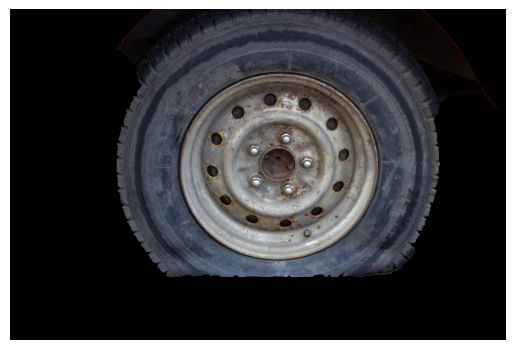

In [1395]:
rect = (x, y, x + width, y + height)
# Initialize mask and models for GrabCut
mask = np.zeros(image.shape[:2], np.uint8)  # Create a blank mask (same size as the image)
bgdModel = np.zeros((1, 65), np.float64)  # Background model (used by GrabCut)
fgdModel = np.zeros((1, 65), np.float64)  # Foreground model (used by GrabCut)

# Apply the GrabCut algorithm to segment the image
cv2.grabCut(blurred, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Create a binary mask to extract the foreground
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")  # Keep foreground pixels (1), remove background (0)
foreground = image * mask2[:, :, np.newaxis]  # Apply the mask to the original image to extract the foreground

# Show the extracted foreground
printimg(foreground)


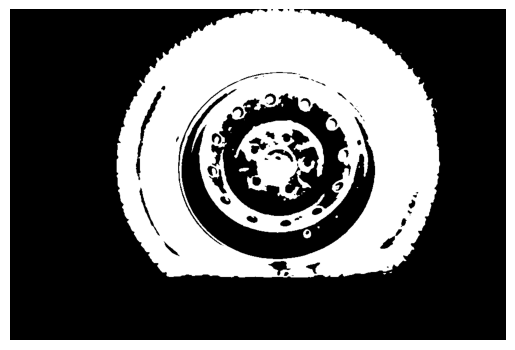

In [1396]:
# Convert the foreground image to grayscale
gray = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to the grayscale image to reduce noise
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# Apply binary thresholding to create a black-and-white image
# Pixels brighter than 40 are set to 255 (white), others to 0 (black)
# _, dst = cv2.threshold(blurred, 35, 255, cv2.THRESH_BINARY)
# 创建一个掩码，灰度值在范围内的设置为255，范围外设置为0
dst = cv2.inRange(blurred, 35, 115)

# Show the thresholded image
printimg(dst)


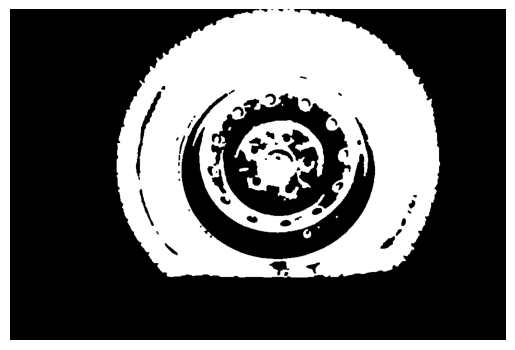

In [1397]:
# Create a rectangular structuring element (kernel) for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Make a copy of the thresholded image for processing
morph_dst = dst.copy()

# Apply morphological operations (opening and closing) 3 times
for _ in range(20):
    # Morphological opening: removes small noise (erode, then dilate)
    morph_dst = cv2.morphologyEx(morph_dst, cv2.MORPH_OPEN, kernel)
    # Morphological closing: fills small holes (dilate, then erode)
    morph_dst = cv2.morphologyEx(morph_dst, cv2.MORPH_CLOSE, kernel)

# Show the result after morphological operations
printimg(morph_dst)


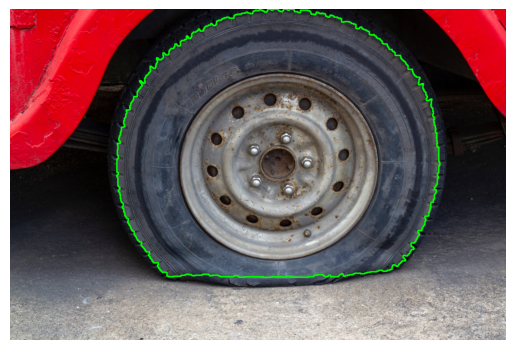

In [1398]:
# Detect contours in the processed image
cont, hier = cv2.findContours(morph_dst, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour based on area
largest_contour = max(cont, key=cv2.contourArea)

# Create a copy of the original image to draw the contour
contoured_image = image.copy()

# Draw the largest contour on the image in green with a thickness of 2
contoured_image = cv2.drawContours(contoured_image, [largest_contour], -1, (0, 255, 0), 2)

# Show the image with the largest contour highlighted
printimg(contoured_image)


Area of symmetric difference: 20029
The tire might be deflated


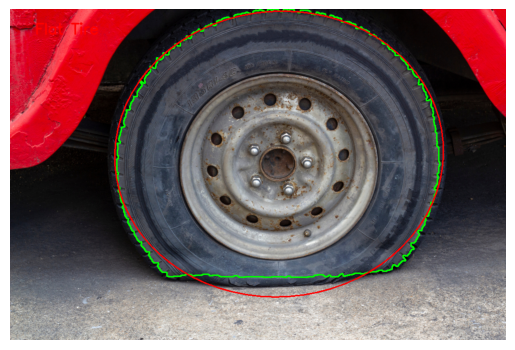

In [1399]:
# Create masks the same size as the original image
mask_shape = image.shape[:2]  # Get height and width of the image
contour_mask = np.zeros(mask_shape, dtype=np.uint8)  # Mask for the contour
ellipse_mask = np.zeros(mask_shape, dtype=np.uint8)  # Mask for the ellipse

# 1. Draw the mask for the contour
cv2.drawContours(contour_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

# 2. Fit and draw an ellipse if the contour has enough points
if len(largest_contour) >= 5:  # At least 5 points are required to fit an ellipse
    min_enclosing_ellipse = cv2.fitEllipse(largest_contour)  # Fit the ellipse
    cv2.ellipse(ellipse_mask, min_enclosing_ellipse, 255, thickness=cv2.FILLED)  # Draw the ellipse

    # 3. Find the intersection and union of the contour and ellipse masks
    intersection = cv2.bitwise_and(contour_mask, ellipse_mask)  # Overlapping regions
    union = cv2.bitwise_or(contour_mask, ellipse_mask)  # Combined regions

    # Calculate the area of intersection and union
    intersection_area = np.sum(intersection == 255)  # Count white pixels in the intersection
    union_area = np.sum(union == 255)  # Count white pixels in the union

    # 4. Calculate the area of the non-overlapping regions (symmetric difference)
    symmetric_difference_area = union_area - intersection_area
    print(f"Area of symmetric difference: {symmetric_difference_area}")

    # Check if the tire might be deflated based on the area difference
    if (symmetric_difference_area / union_area) > 1 / 20:  # Threshold for deflation
        print("The tire might be deflated")
        # Add red text "flat tire" on the contoured image
        cv2.putText(contoured_image, "Flat Tire", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    else:
        print("The tire is properly inflated")
        # Add red text "normal tire" on the contoured image
        cv2.putText(contoured_image, "Normal Tire", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)


    # Draw the ellipse on the image in red
    cv2.ellipse(contoured_image, min_enclosing_ellipse, (0, 0, 255), thickness=2)

# Show the image with the contour and ellipse
printimg(contoured_image)
